In [19]:
from skimage.io import imread
import numpy as np
from scipy.fftpack import dct, idct
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import time
from google.colab import drive


In [20]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Useful function for plot the 2D DCT dictionary

In [21]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Load the image and rescale it in $[0,1]$

In [22]:
#img = imread(f'{rootfolder}/data/cameraman.png') / 255
#img = imread(f'{rootfolder}/data/barbara.png') / 255
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [23]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [24]:
mse_noisy = ((img-noisy_img)**2).mean()
psnr_noisy= 10*np.log10(1/mse_noisy)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.12')

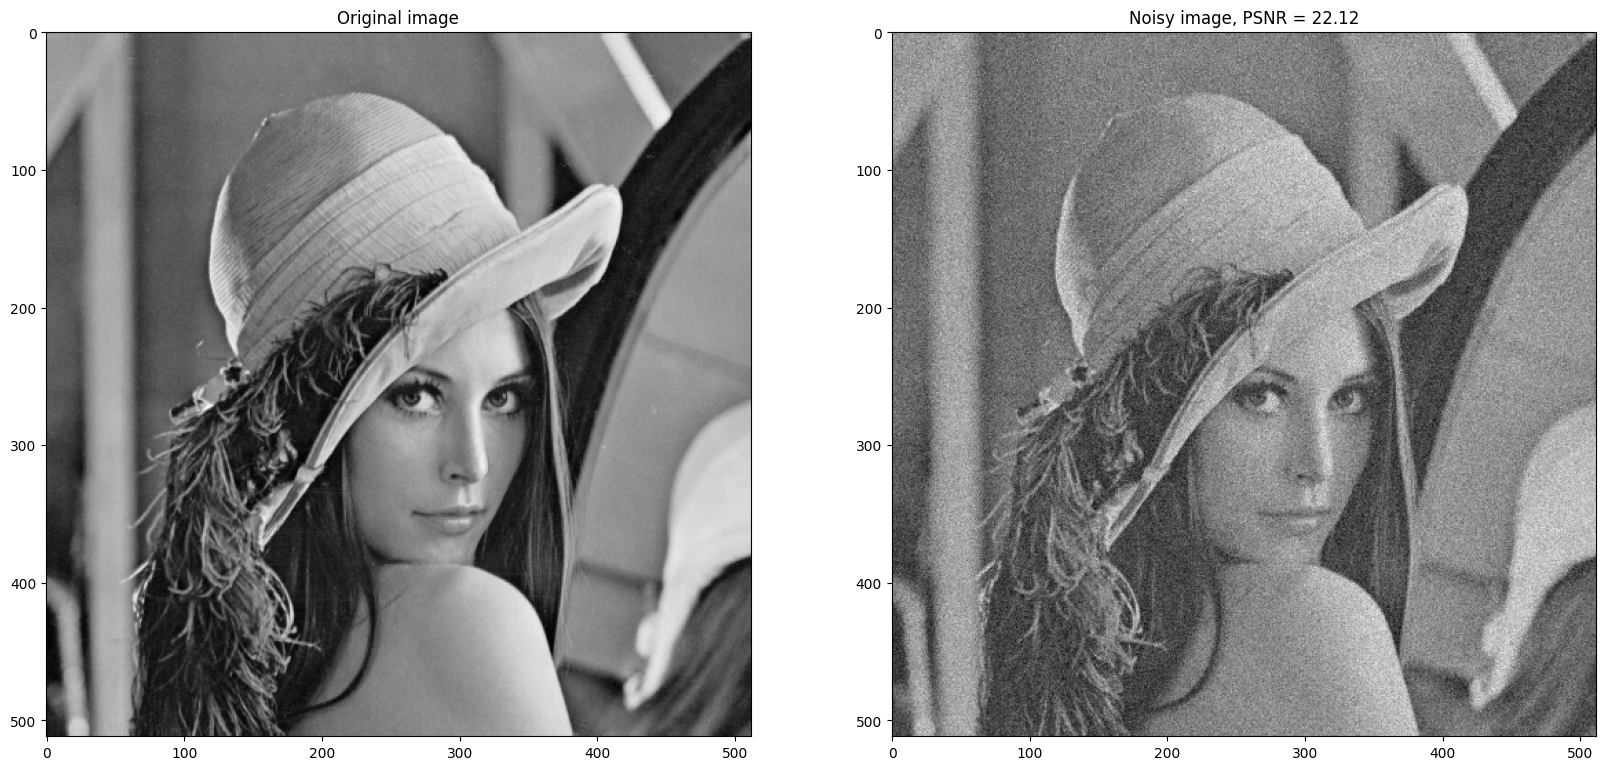

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Generate the Global PCA basis for this image
--------------------------------------------

Set the parameters for denoising

In [26]:
# thresholds on perc. explained variances
PERC_EX_VAR_THRESHOLD = 0.8

# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise 
# Donoho says: sigma * sqrt(2*log(p^2))

# this boolean tells us if we are interested in doing the HT or not
DO_HT = True


Stack all the image patches in a large matrix $P$. Each patch goes in a column of $P$

In [27]:
count = 0
STEP = 1
W= (imsz[0]-p+1)**2
P = np.zeros((M,W))
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p,j:j+p].reshape(M)
        P[:,count] = s
        count = count+1


Zero center $P$


In [28]:
avg_patch = P.mean(axis=1) # compute the mean over the rows
Pc = np.zeros_like(P)
for i in range(W):
  Pc[:,i] = P[:,i] - avg_patch

Compute the PCA transformation via SVD


In [29]:
U, Sigma, V = np.linalg.svd(Pc@Pc.T, full_matrices=False, compute_uv=True)

Show the learned PCA basis

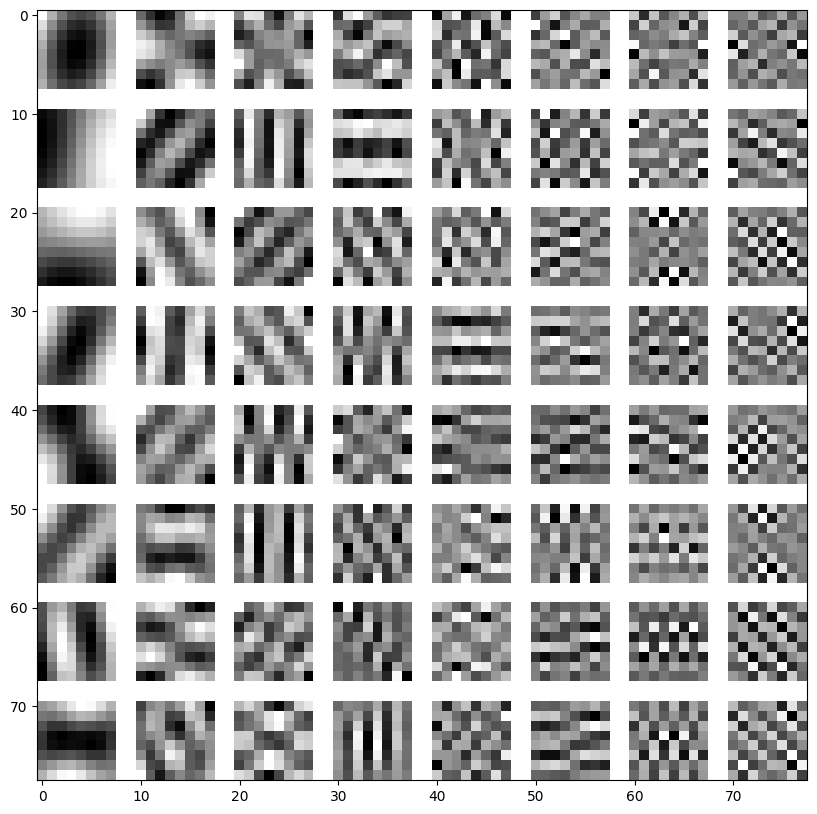

In [30]:
U_img = get_dictionary_img(U)
plt.figure(figsize=(10,10))
plt.imshow(U_img, cmap='gray')


Select only the first components that explained enough variance

3


Text(0.5, 1.0, 'Explained variances of 2D PCA- learned')

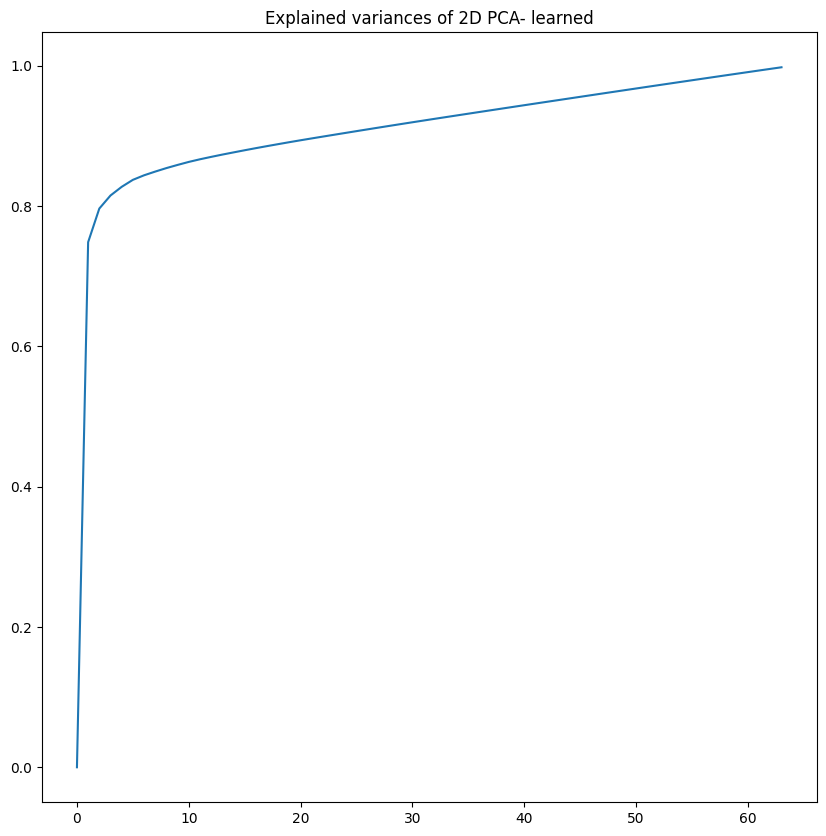

In [31]:
cumulative_percentage = np.zeros(M)
var_k= np.zeros(M)
var_M= np.sum(Sigma)
for i in range(M):
  var_k[i]= np.sum(Sigma[0:i])
  cumulative_percentage[i]= var_k[i]/var_M

k = np.argmax(cumulative_percentage >= PERC_EX_VAR_THRESHOLD)
print(k) 

plt.figure(figsize=(10,10))
plt.plot(cumulative_percentage)
plt.title('Explained variances of 2D PCA- learned')


Define the PCA projection

In [32]:
# U up until k-th component
Uk = U[:,0:k]
# make sure that Uk is square so we will be able to invert it

Patch-based denoising
---------------------
Initialize the variables

In [33]:
STEP = 1

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [34]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p,j:j+p].flatten()

        # Preprocessing: remember to subtract the avg_patch (preprocessing used for PCA)
        s =  s - avg_patch

        if DO_HT:
            # compute the representation w.r.t. the PCA basis
            x = U.T@s

            # perform the hard thresholding
            x_HT = x.copy()
            x_HT[np.abs(x_HT)<=tau] = 0
            x_HT[0]=x[0]  

            # synthesis: perform the reconstruction
            s_hat = U@x_HT

        else:
            # NO HT PERFORMED
            # compute the projection on the basis defined by Uk
            x_hat = (Uk.T)@s
            # invert the projection
            s_hat = Uk@x_hat

        # add the avg patch back
        s_hat = s_hat + avg_patch

        # compute the weight for the reconstructed patch
        w = 1

        # put the compressed patch into the compressed image using the computed weight
        # UPDATE img_hat
        img_hat[i:i+p,j:j+p] += (s_hat.reshape((p,p))) * w


        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        weights[i:i+p,j:j+p] += np.full((p,p),w)

# normalize the estimated image with the computed weights
img_hat = img_hat / weights


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 32.22')

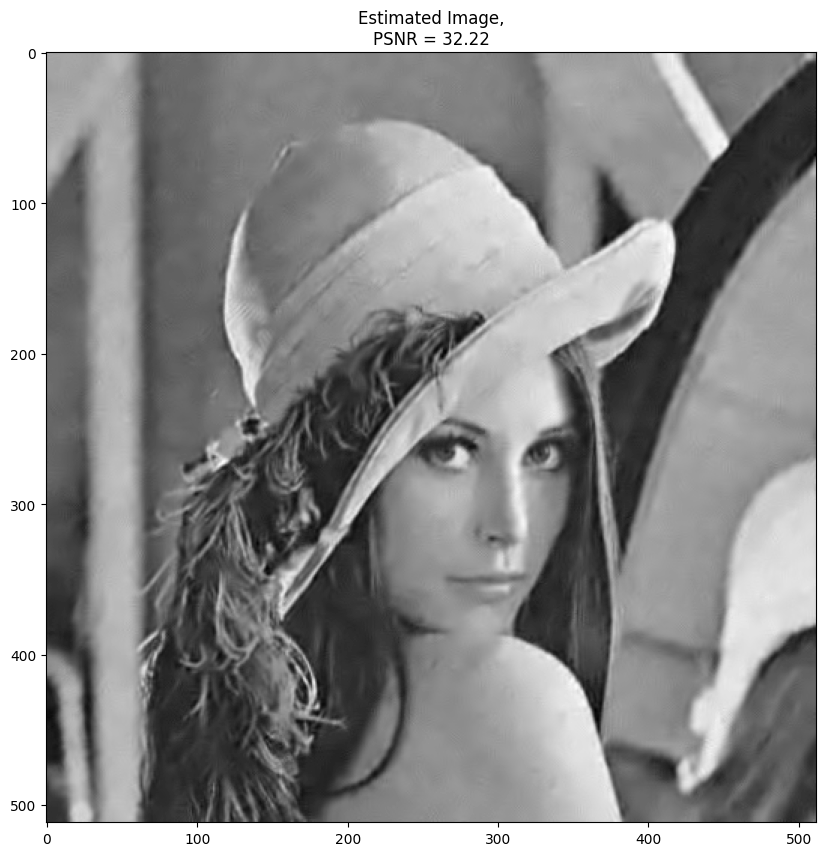

In [35]:
psnr_hat = 10*np.log10(1/((img_hat-img)**2).mean())
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
